<a href="https://colab.research.google.com/github/yuichiro6147/heat-japan-map/blob/master/report_to_map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 必要なライブラリをインストール

In [0]:
#地図
!pip install japanmap
!pip install japanize-matplotlib

In [0]:
#Googleスプレッドシート
!pip install --upgrade --quiet gspread

# 都道府県コードと県名の辞書

In [0]:
prefecturesDictionary = {
  '01': '北海道',
  '02': '青森',
  '03': '岩手',
  '04': '宮城',
  '05': '秋田',
  '06': '山形',
  '07': '福島',
  '08': '茨城',
  '09': '栃木',
  '10': '群馬',
  '11': '埼玉',
  '12': '千葉',
  '13': '東京',
  '14': '神奈川',
  '15': '新潟',
  '16': '富山',
  '17': '石川',
  '18': '福井',
  '19': '山梨',
  '20': '長野',
  '21': '岐阜',
  '22': '静岡',
  '23': '愛知',
  '24': '三重',
  '25': '滋賀',
  '26': '京都',
  '27': '大阪',
  '28': '兵庫',
  '29': '奈良',
  '30': '和歌山',
  '31': '鳥取',
  '32': '島根',
  '33': '岡山',
  '34': '広島',
  '35': '山口',
  '36': '徳島',
  '37': '香川',
  '38': '愛媛',
  '39': '高知',
  '40': '福岡',
  '41': '佐賀',
  '42': '長崎',
  '43': '熊本',
  '44': '大分',
  '45': '宮崎',
  '46': '鹿児島',
  '47': '沖縄'
}

# Googleスプレッドシートを開く

In [0]:
from google.colab import auth
# 認証
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

# スプレッドシートを読み込む
worksheet = gc.open('人口(2018年)').sheet1

# panda形式に変換
import pandas as pd
dataset = pd.DataFrame(worksheet.get_all_values())

# 集計処理

In [0]:
# 0行目を列名にする
dataset.columns =  list(dataset.iloc[0])
dataset.drop(0, inplace=True)
dataset = dataset.reset_index(drop=True)

# 事業所番号から都道府県名に変換する関数
def toPrefecturesName(val):
  code = val[:2] # 0番目から1番目までの文字(事業所番号の先頭2文字)
  return prefecturesDictionary.get(code)

# カンマで桁区切りされた数値をプレーンな数値に変換する関数(1,234 -> 1234)
def toFlatInt(val):
  return int(val.replace(',', ''))

# 事業所番号を都道府県名に変換
dataset['事業所番号'] = dataset['事業所番号'].map(toPrefecturesName)
# ラベルも変更
dataset = dataset.rename(columns={'事業所番号': '都道府県名'})
# 総額をフラットな数値に変換
dataset['総額'] = dataset['総額'].map(toFlatInt)

# 都道府県コードで集約し、総額は合計する
dataset = dataset.groupby('都道府県名', as_index=False).sum()

# 必要部分を抜き出し、pandas 形式を numpy 形式に変換する
from decimal import Decimal, ROUND_HALF_UP, ROUND_HALF_EVEN
values = dataset.loc[:, ['総額']].values
# 総額を千円単位にした配列を作成
total_amounts = [int(value / 1000) for value in values]

# 色の塗り方を指定
## 配色は[ヒートマップ](https://ui.userlocal.jp/functions/heatmap/)形式を採用


In [0]:
column_name = '総額'

color_map = {}

# 平均
mean = np.mean(dataset[column_name])
# 最大
max_value = np.max(dataset[column_name])
# 最小
min_value = np.min(dataset[column_name])

for index, row in dataset.sort_values(column_name, ascending=False).iterrows():        
    prefecture = row['都道府県名']
    value = row[column_name]
    # 平均未満
    if mean > value:
        red_value = int(255 - 255 * (mean - value) / (mean - min_value))
        red = str(hex(red_value))[2:]
        if len(red) == 1:
            red = "0" + red
            
        color_map[prefecture] = "#" + red + "FF00"
    # 平均以上
    else:
        green_value = int(255 - 255 * (value - mean) / (max_value - mean))
        green = str(hex(green_value))[2:]
        if len(green) == 1:
            green = "0" + green
        
        color_map[prefecture] = "#FF" + green + "00"

# colormapをカスタマイズする

In [0]:
from matplotlib.colors import LinearSegmentedColormap

def generate_cmap(colors):
    """自分で定義したカラーマップを返す"""
    values = range(len(colors))

    vmax = np.ceil(np.max(values))
    color_list = []
    for v, c in zip(values, colors):
        color_list.append( ( v/ vmax, c) )
    return LinearSegmentedColormap.from_list('custom_cmap', color_list)

# 地図に色を塗って出力する

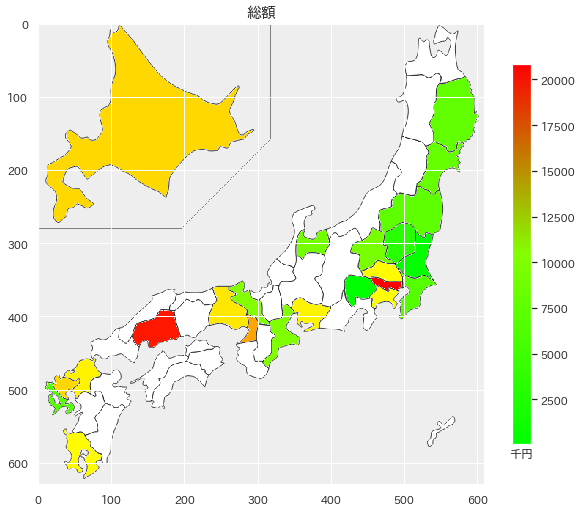

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from japanmap import picture
import matplotlib.cm
from matplotlib.colors import Normalize
import japanize_matplotlib
import seaborn as sns
sns.set(font="IPAexGothic") #日本語フォント設定

# カラーバーをカスタム
color_keys = list(color_map.keys())
first_key = color_keys[0]
middle_key = color_keys[int(len(color_keys) / 2)]
last_key = color_keys[len(color_keys) - 1]

# カラーマップ生成
cmap = generate_cmap([color_map[last_key], color_map[middle_key], color_map[first_key]])

plt.subplots(figsize=(10, 10))

norm = Normalize()
mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
mapper.set_array(total_amounts)
colorbar = plt.colorbar(mapper, shrink=0.7)
colorbar.ax.set_xlabel('千円')

plt.title(column_name, fontsize=15)
plt.imshow(picture(color_map));